In [1]:
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from keras.utils import normalize
import warnings
warnings.filterwarnings('ignore')

2024-01-07 19:55:43.760543: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-07 19:55:43.760641: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-07 19:55:43.994654: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-07 19:55:44.809601: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-07 19:56:02.942155: W tensorflow/compiler/tf2

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-01-07 19:56:56.506102: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-07 19:56:58.250710: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-07 19:56:58.251049: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
data_file="./data"

In [4]:
train_data_dir =data_file
batch_size = 32
target_size = 254
validation_split = 0.2

train= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="training",
    seed=10,
    image_size=(target_size,target_size),
    batch_size=batch_size,
)
validation= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=10,
    image_size=(target_size,target_size),
    batch_size=batch_size,
)



Found 3096 files belonging to 4 classes.
Using 2477 files for training.


2024-01-07 19:57:04.082853: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-07 19:57:04.083689: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-07 19:57:04.084581: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Found 3096 files belonging to 4 classes.
Using 619 files for validation.


In [5]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [6]:
x_normalized_train = train.map(lambda x,y:(normalization_layer(x),y))
y_normalized_train = validation.map(lambda x,y:(normalization_layer(x),y))
#x_normalized_train = normalize(train,axis=1)

#y_normalized_train = normalize(validation,axis=1)

In [7]:
edy = x_normalized_train.as_numpy_iterator()
len(edy.next())

2

In [8]:
model=tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(target_size,target_size,3)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(tf.keras.layers.Conv2D(32,(3,3),kernel_initializer='he_uniform',activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))


model.add(tf.keras.layers.Conv2D(64,(3,3),kernel_initializer='he_uniform',activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))


model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.Dropout(.5))
model.add(tf.keras.layers.Dense(4,activation=tf.nn.softmax))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 126, 126, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 64)        0

In [9]:

model.compile(optimizer='adam',
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[tf.metrics.SparseCategoricalAccuracy()])


In [10]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="my_keras_model.h5",
                                                 save_weights_only=True,
                                                 verbose=1)
model.fit_generator(x_normalized_train,epochs=10,validation_data=y_normalized_train,callbacks=[cp_callback])

Epoch 1/10


2024-01-07 19:57:23.982806: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-07 19:57:25.653703: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-07 19:57:32.643921: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f66d93eb160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-07 19:57:32.644018: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1050, Compute Capability 6.1
2024-01-07 19:57:32.733413: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1704653853.350306    9087 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


78/78 [==============================] - ETA: 0s - loss: 1.3497 - sparse_categorical_accuracy: 0.3823
Epoch 1: saving model to my_keras_model.h5
78/78 [==============================] - 53s 415ms/step - loss: 1.3497 - sparse_categorical_accuracy: 0.3823 - val_loss: 1.1186 - val_sparse_categorical_accuracy: 0.5767
Epoch 2/10
78/78 [==============================] - ETA: 0s - loss: 1.0499 - sparse_categorical_accuracy: 0.5486
Epoch 2: saving model to my_keras_model.h5
78/78 [==============================] - 23s 289ms/step - loss: 1.0499 - sparse_categorical_accuracy: 0.5486 - val_loss: 0.8798 - val_sparse_categorical_accuracy: 0.6575
Epoch 3/10
78/78 [==============================] - ETA: 0s - loss: 0.8280 - sparse_categorical_accuracy: 0.6528
Epoch 3: saving model to my_keras_model.h5
78/78 [==============================] - 23s 294ms/step - loss: 0.8280 - sparse_categorical_accuracy: 0.6528 - val_loss: 0.6700 - val_sparse_categorical_accuracy: 0.7431
Epoch 4/10
78/78 [===============

In [14]:
score, acc = model.evaluate(y_normalized_train)
print('Test Loss =', score)
print('Test Accuracy =', acc)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

20/20 [==============================] - 2s 78ms/step - loss: 0.4052 - sparse_categorical_accuracy: 0.8562
Test Loss = 0.4051502048969269
Test Accuracy = 0.8562197089195251
Untrained model, accuracy: 85.62%


In [12]:
model.save("brain_tumors.keras")

In [13]:
model = tf.keras.models.load_model("brain_tumors.keras")

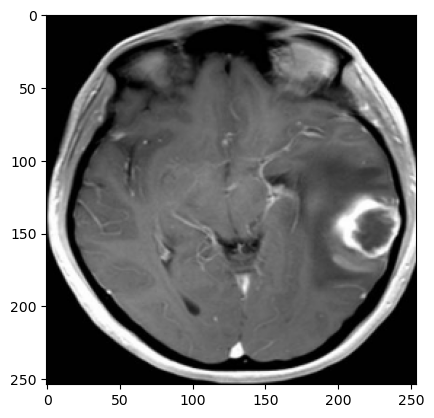

In [15]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
img  = cv2.imread('./test/test2.jpg')
img = cv2.resize(img,(254,254))
img  = Image.fromarray(img)

plt.imshow(img)

In [16]:
img_normalized=tf.image.per_image_standardization(img)

In [17]:
img_normalized

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


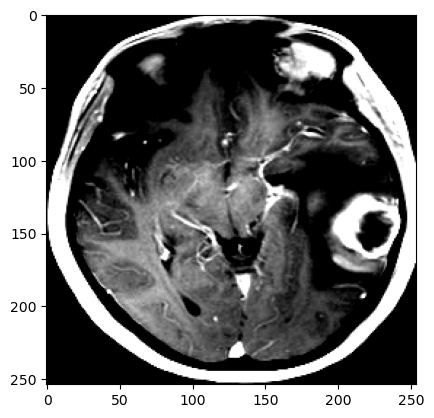

In [18]:
plt.imshow(img_normalized)


In [19]:
class_names = train.class_names

In [20]:

prediction = model.predict(img_normalized.reshape(1,254,254,3))

prediction 

index = prediction.argmax()

print(class_names)
print(prediction)
print(class_names[prediction.argmax()])

1/1 [==============================] - 1s 1s/step
['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']
[[1.2608430e-16 6.3380738e-11 5.0062594e-19 1.0000000e+00]]
pituitary_tumor
